### steps

1. load `TrainAndValid.csv` file with `low_memory=False, parse_dates=["saledate"]`
2. sort the dataset with saledate in ascending order
3. drop the features that have more than 350000 missing values
4. fill the missing values of numerical features with the median value
5. turn the string/object datatype features to category
6. add binary columns to strore the information whether it has missing values
7. Turn the categories into number and add 1, because if there is missing values, it's value will be $-1$. So, to make the numbers non-negative, 1 is added.
8. split our dataset into train and valid
9. using RandomizedSearchCV to search the best parameters for an algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("default")

In [2]:
df = pd.read_csv("data/TrainAndValid.csv",
                 low_memory=False,
                 parse_dates=["saledate"])
df.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [4]:
df.shape

(412698, 53)

In [9]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06


#### Sort dataframe by saledate

In [3]:
# pandas uses quicksort algorithm for sorting by default. Others available: heapsort, mergesort
df.sort_values(by=["saledate"], inplace=True)
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

#### missing data visualization

In [29]:
import missingno

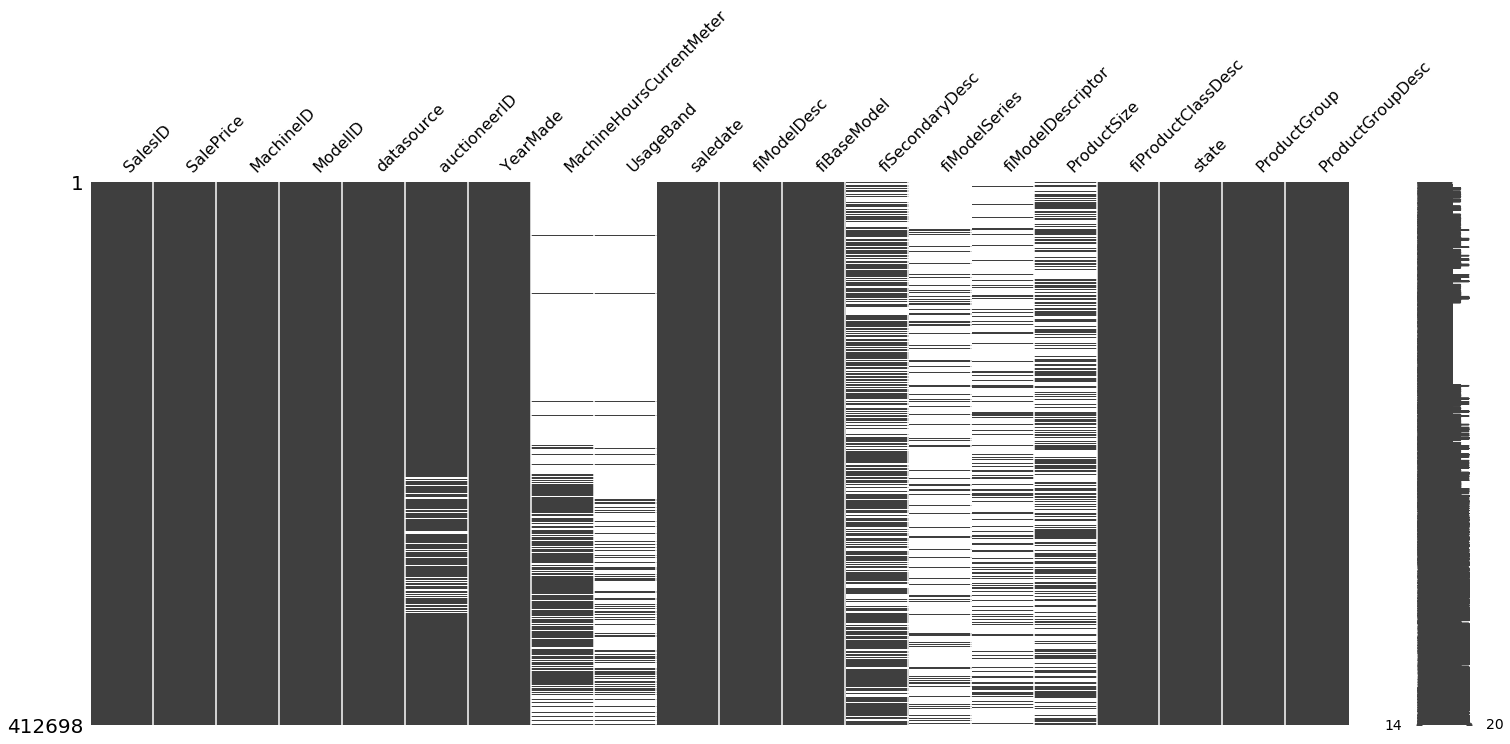

In [30]:
missingno.matrix(df.iloc[:, :20]);

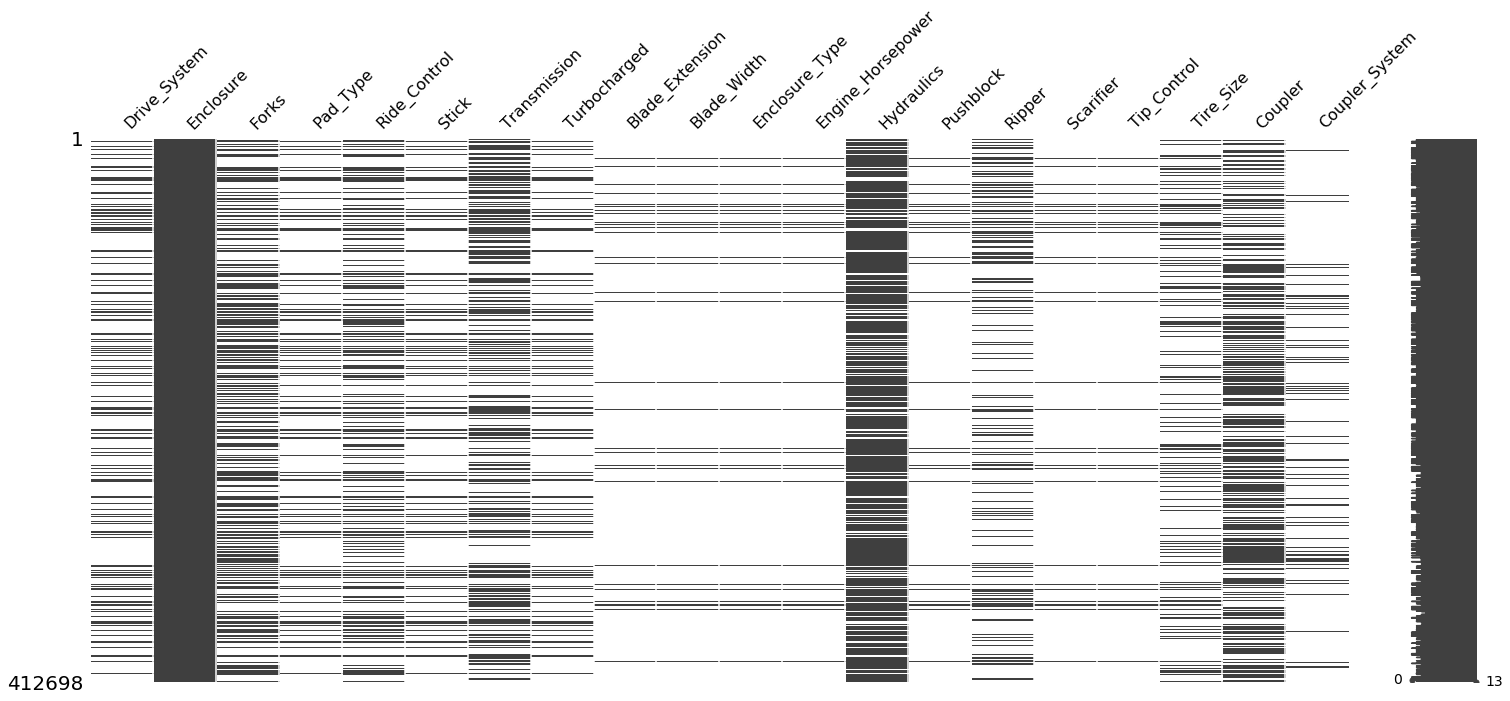

In [31]:
missingno.matrix(df.iloc[:, 20:40]);

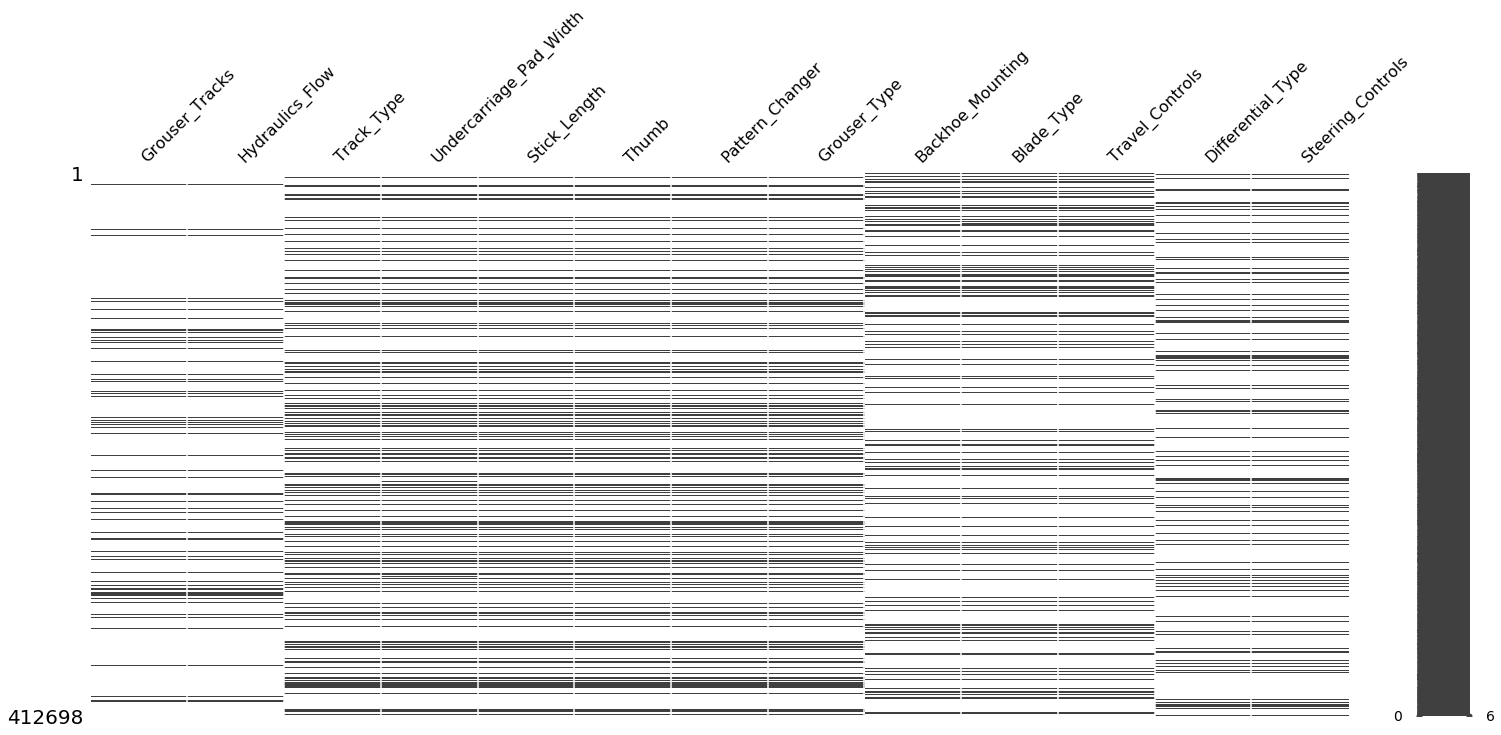

In [32]:
missingno.matrix(df.iloc[:, 40:]);

#### Dataset length=412698, dropping the features that have more than 350000 missing values

In [4]:
null_values = dict(df.isna().sum())

In [5]:
most_missing_features = []
for key, val in null_values.items():
    if val > 350000:
        most_missing_features.append(key)

In [7]:
most_missing_features

['fiModelSeries',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Pushblock',
 'Scarifier',
 'Tip_Control',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow']

#### making a copy of the dataset

In [7]:
df_tmp = df.copy()

In [40]:
df_tmp.saledate[:5]

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [8]:
for val in most_missing_features:
    df_tmp.drop(val, axis=1, inplace=True)

In [10]:
df.shape, df_tmp.shape

((412698, 53), (412698, 42))

### Using pandas datetime API

In [9]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDate"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [45]:
df_tmp.shape

(412698, 47)

#### dropping `saledate` column

In [10]:
df_tmp.drop("saledate", axis=1, inplace=True)
df_tmp.shape

(412698, 46)

In [47]:
df_tmp.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Hydraulics',
       'Ripper', 'Tire_Size', 'Coupler', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleDate', 'saleDayOfWeek', 'saleDayOfYear'],
      dtype='object')

## fill the columns that have numerical missing values

In [48]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [51]:
df_tmp.auctioneerID.describe()

count    392562.000000
mean          6.585268
std          17.158409
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          99.000000
Name: auctioneerID, dtype: float64

In [52]:
df_tmp.auctioneerID.median()

2.0

In [11]:
df_tmp.fillna(value=df_tmp.auctioneerID.median(), inplace=True)

In [58]:
df_tmp.auctioneerID.isna().sum(), df.auctioneerID.isna().sum()

(0, 20136)

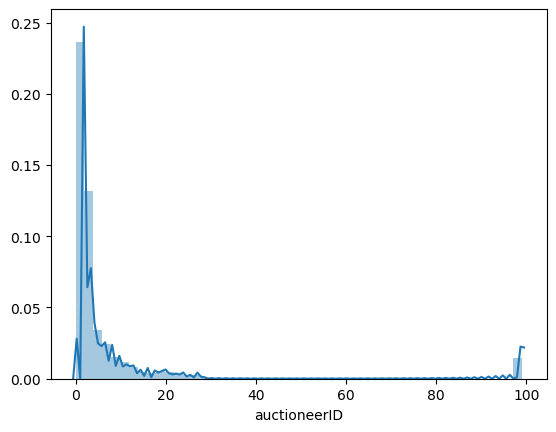

In [59]:
sns.distplot(df_tmp.auctioneerID);

In [76]:
len(df_tmp.loc[df_tmp['auctioneerID'] == 99])

12042

In [77]:
df_tmp.MachineHoursCurrentMeter.describe()

count    4.126980e+05
mean     1.260450e+03
std      1.633067e+04
min      0.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.483300e+06
Name: MachineHoursCurrentMeter, dtype: float64

In [78]:
df_tmp.MachineHoursCurrentMeter.median()

2.0

In [12]:
df_tmp.fillna(value=df_tmp.MachineHoursCurrentMeter.median(), inplace=True)

In [80]:
df_tmp.MachineHoursCurrentMeter.isna().sum(), df.MachineHoursCurrentMeter.isna().sum()

(0, 265194)

## fill the columns that have missing string values

In [81]:
df_tmp.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                 object
Hydraulics                   object
Ripper                      

In [82]:
# check the columns that are not numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Hydraulics
Ripper
Tire_Size
Coupler
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


### Turn string value into categories

In [13]:
# label = column name(key), content = values in the column
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [87]:
df_tmp.state.cat.categories
# pd.Categorical(df_tmp["state"]).categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [88]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [14]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add 1
        df_tmp[label] = pd.Categorical(df_tmp["state"]).codes + 1

In [90]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 79, dtype: int64

### split our data into train and test

In [15]:
# split data into train and validation
df_train = df_tmp[df_tmp["saleYear"] < 2012]
df_valid = df_tmp[df_tmp["saleYear"] == 2012]
len(df_valid)

11573

In [16]:
# split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_valid.drop("SalePrice", axis=1), df_valid["SalePrice"]

## Build the model

### Try with `RandomForest`

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
%%time

# Instantiating model
model = RandomForestRegressor(n_jobs=-1, random_state=42)
# fit the model
model.fit(X_train, y_train)

Wall time: 14min 2s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [18]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

In [19]:
def rmsle(y_test, y_pred):
    """
    Calculate root measn squared log error between test data and predicted data
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

In [20]:
def show_score(model):
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_pred),
              "Validation MAE": mean_absolute_error(y_valid, valid_pred),
              "Training RMSLE": rmsle(y_train, train_pred),
              "Validation RMSLE": rmsle(y_valid, valid_pred),
              "Training R^2": r2_score(y_train, train_pred),
              "Validation R^2": r2_score(y_valid, valid_pred)}
    return scores

In [99]:
show_score(model)

{'Training MAE': 1859.2817412028674,
 'Validation MAE': 7618.568767821655,
 'Training RMSLE': 0.1040700457507392,
 'Validation RMSLE': 0.33674937487862744,
 'Training R^2': 0.9826242692456258,
 'Validation R^2': 0.7991921657655778}

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [101]:
%%time

estimator = RandomForestRegressor(n_jobs=-1, random_state=42)
param_distribution = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(2, 20, 2),
    "max_features": ["auto", "sqrt", 0.5],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(estimator,
                              param_distribution,
                              cv=5,
                              n_iter=20,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 16.1min finished


Wall time: 16min 26s
Compiler : 130 ms
Parser   : 240 ms


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 3],
                                        'max_features': ['auto', 'sqrt', 0.5],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [106]:
pd.DataFrame(rs_model.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'param_min_samples_split',
       'param_min_samples_leaf', 'param_max_samples', 'param_max_features',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [105]:
pd.DataFrame(rs_model.cv_results_)[["param_n_estimators",
                                    "param_max_depth",
                                    "param_min_samples_split",
                                    "param_min_samples_leaf",
                                    "param_max_features",
                                    "param_max_samples",
                                    "mean_test_score",
                                    "rank_test_score"]]

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_samples,mean_test_score,rank_test_score
0,50,None,4,16,sqrt,10000,0.253536,13
1,60,None,18,6,sqrt,10000,0.287067,6
2,50,None,8,4,sqrt,10000,0.302311,5
3,10,None,16,4,sqrt,10000,0.274538,10
4,40,None,14,16,auto,10000,0.567780,2
5,20,3,12,16,0.5,10000,0.194038,17
6,50,3,4,8,0.5,10000,0.199005,16
7,40,3,2,16,sqrt,10000,0.088011,20
8,70,3,8,12,sqrt,10000,0.088819,19
9,40,None,18,6,sqrt,10000,0.286252,7


In [107]:
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 6,
 'min_samples_leaf': 14,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [108]:
rs_model.best_score_

0.5768345252159369

In [109]:
%%time

show_score(rs_model)

Wall time: 6.01 s


{'Training MAE': 8798.420802711165,
 'Validation MAE': 12161.28130318835,
 'Training RMSLE': 0.4003829963123647,
 'Validation RMSLE': 0.4993622146272506,
 'Training R^2': 0.6693546663641894,
 'Validation R^2': 0.5605291638732122}

#### RandomizedSearchCV for `n_iter=50`

In [110]:
%%time

estimator = RandomForestRegressor(n_jobs=-1, random_state=42)
param_distribution = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(2, 20, 2),
    "max_features": ["auto", "sqrt", 0.5],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(estimator,
                              param_distribution,
                              cv=5,
                              n_iter=50,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 42.8min finished


Wall time: 43min 3s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 3],
                                        'max_features': ['auto', 'sqrt', 0.5],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [111]:
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [112]:
rs_model.best_score_

0.6331468617859095

In [113]:
%%time

show_score(rs_model)

Wall time: 5.32 s


{'Training MAE': 7684.597425723192,
 'Validation MAE': 11361.801807192849,
 'Training RMSLE': 0.36118957395488477,
 'Validation RMSLE': 0.48312369307442865,
 'Training R^2': 0.7417071707699855,
 'Validation R^2': 0.6281421224576589}

### fit the whole training data with the best score

In [24]:
%%time

ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_split=6,
                                    min_samples_leaf=2,
                                    max_samples=None,
                                    max_features="auto",
                                    n_jobs=-1,
                                    random_state=42)

ideal_model.fit(X_train, y_train)

Wall time: 4min 57s


RandomForestRegressor(min_samples_leaf=2, min_samples_split=6, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [25]:
%%time

show_score(ideal_model)

Wall time: 12.1 s


{'Training MAE': 2618.6356625087974,
 'Validation MAE': 7543.781110374438,
 'Training RMSLE': 0.14099308126133647,
 'Validation RMSLE': 0.3325818281250507,
 'Training R^2': 0.9631248003747597,
 'Validation R^2': 0.7993556349369204}

##### the model built with default values:

```py
{'Training MAE': 1859.2817412028674,
 'Validation MAE': 7618.568767821655,
 'Training RMSLE': 0.1040700457507392,
 'Validation RMSLE': 0.33674937487862744,
 'Training R^2': 0.9826242692456258,
 'Validation R^2': 0.7991921657655778}
```

So, the ideal model is slightly better

### `n_iter=100`

In [22]:
%%time

estimator = RandomForestRegressor(n_jobs=-1, random_state=42)
param_distribution = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(2, 20, 2),
    "max_features": ["auto", "sqrt", 0.5],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(estimator,
                              param_distribution,
                              cv=5,
                              n_iter=100,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 78.8min finished


Wall time: 1h 19min 4s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3],
                                        'max_features': ['auto', 'sqrt', 0.5],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [23]:
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [24]:
rs_model.best_score_

0.6336383452437302

In [25]:
%%time

ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_split=2,
                                    min_samples_leaf=2,
                                    max_samples=None,
                                    max_features="auto",
                                    n_jobs=-1,
                                    random_state=42)

ideal_model.fit(X_train, y_train)

Wall time: 5min 19s


RandomForestRegressor(min_samples_leaf=2, n_estimators=40, n_jobs=-1,
                      random_state=42)

In [26]:
show_score(ideal_model)

{'Training MAE': 2351.298765173864,
 'Validation MAE': 7553.978612483914,
 'Training RMSLE': 0.1291431822618856,
 'Validation RMSLE': 0.3331565924714932,
 'Training R^2': 0.9697485354421861,
 'Validation R^2': 0.7984329603454591}

## EDA of Test data

In [26]:
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.head(3)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [27]:
df_test.sort_values(by=["saledate"], inplace=True)
df_test.saledate

1408    2012-05-01
1023    2012-05-01
1728    2012-05-01
1167    2012-05-01
1594    2012-05-01
           ...    
9941    2012-11-15
9936    2012-11-15
11620   2012-11-15
9995    2012-11-15
9803    2012-11-16
Name: saledate, Length: 12457, dtype: datetime64[ns]

In [28]:
df_test.shape

(12457, 52)

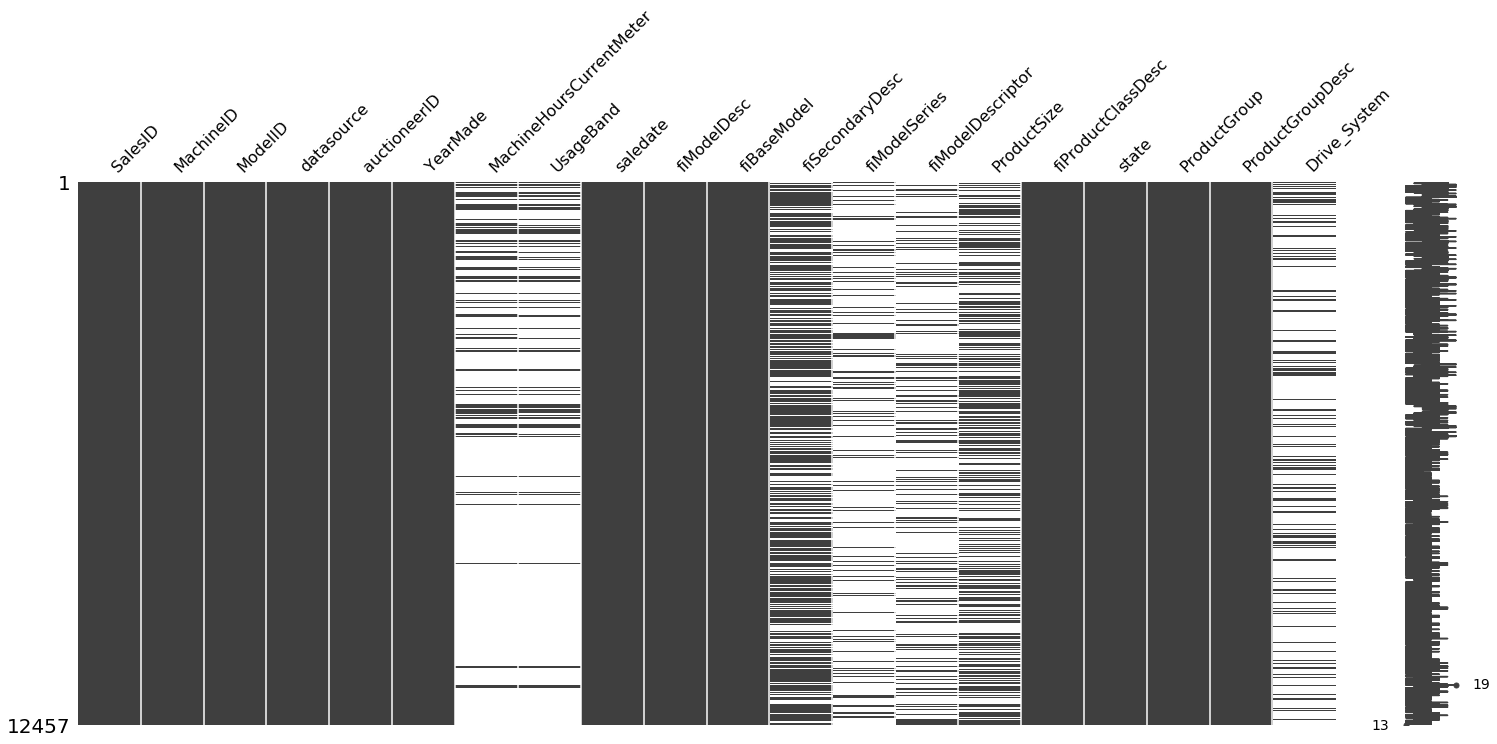

In [30]:
missingno.matrix(df_test.iloc[:, :20]);

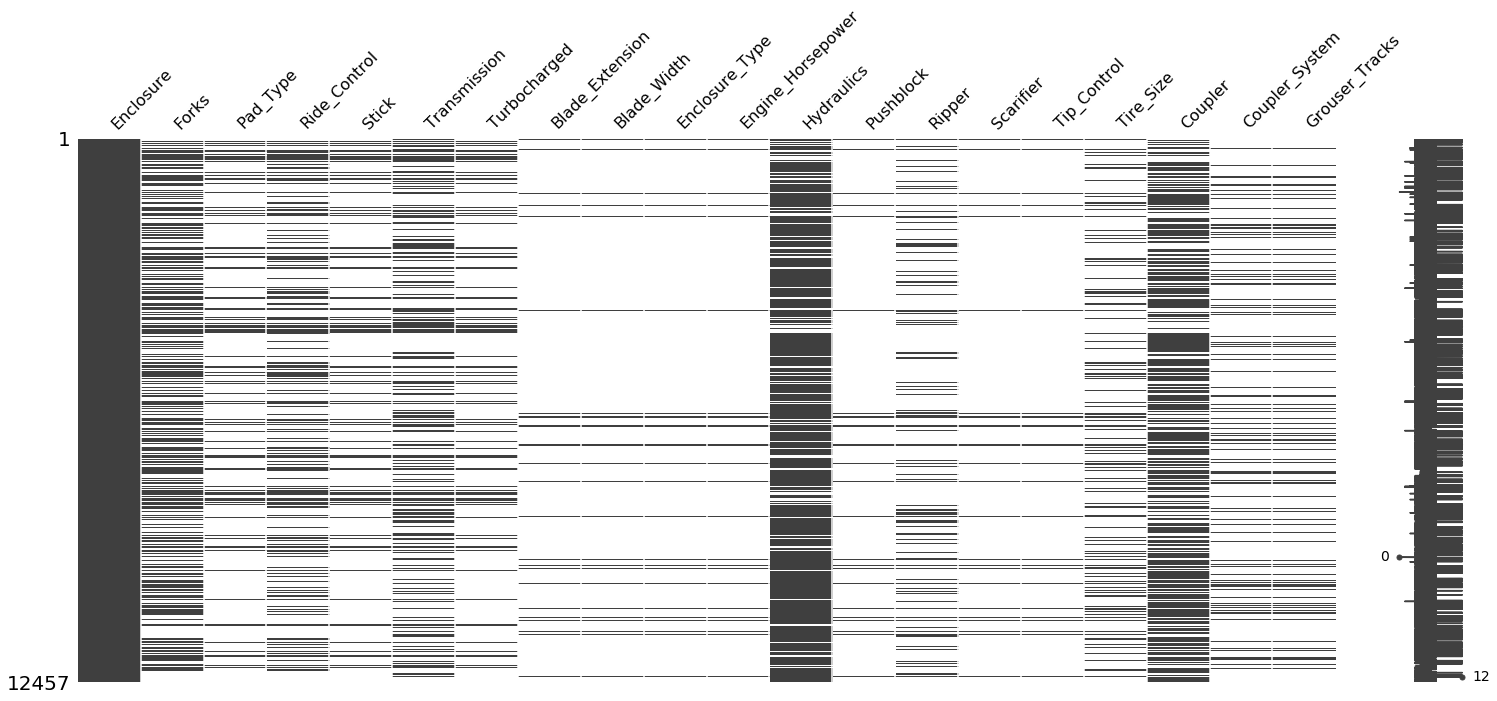

In [35]:
missingno.matrix(df_test.iloc[:, 20:40]);

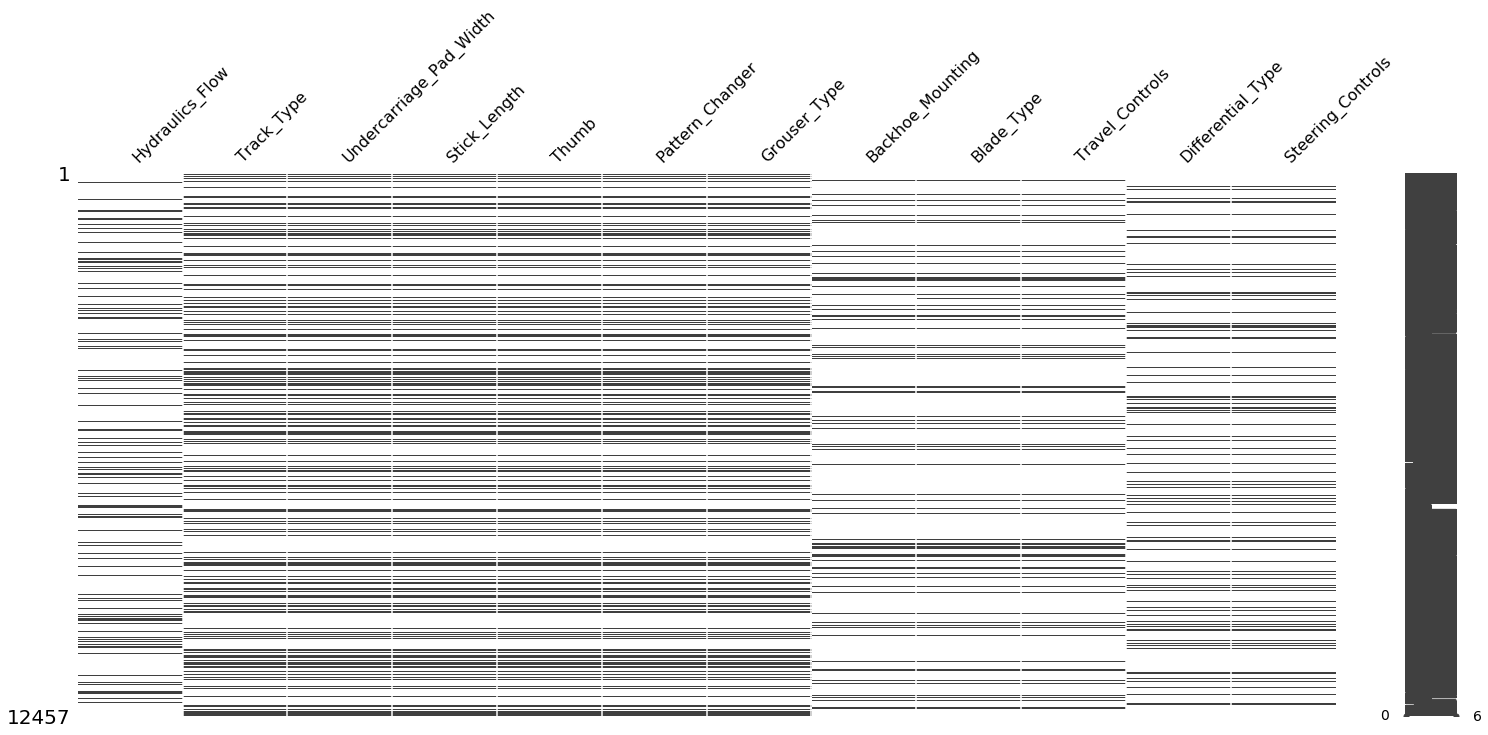

In [36]:
missingno.matrix(df_test.iloc[:, 40:]);

In [33]:
most_missing_features

['fiModelSeries',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Pushblock',
 'Scarifier',
 'Tip_Control',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow']

In [34]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [37]:
df_test_tmp = df_test.copy()

#### drop the `most_missing_features` that was dropped from the training and validation data

In [39]:
for val in most_missing_features:
    df_test_tmp.drop(val, axis=1, inplace=True)

In [40]:
df_test.shape, df_test_tmp.shape

((12457, 52), (12457, 41))

In [41]:
df_test_tmp["saleYear"] = df_test_tmp.saledate.dt.year
df_test_tmp["saleMonth"] = df_test_tmp.saledate.dt.month
df_test_tmp["saleDate"] = df_test_tmp.saledate.dt.day
df_test_tmp["saleDayOfWeek"] = df_test_tmp.saledate.dt.dayofweek
df_test_tmp["saleDayOfYear"] = df_test_tmp.saledate.dt.dayofyear

In [42]:
df_test_tmp.drop("saledate", axis=1, inplace=True)

In [43]:
df_test_tmp.shape

(12457, 45)

#### find numerical missing values column and fill them with the median value

In [44]:
for label, content in df_test_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

MachineHoursCurrentMeter


In [45]:
df_test_tmp.fillna(value=df_test_tmp.MachineHoursCurrentMeter.median(), inplace=True)

In [46]:
df_test_tmp.shape

(12457, 45)

### turn string columns into categories

In [47]:
for label, content in df_test_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_test_tmp[label] = content.astype("category").cat.as_ordered()

#### fill the missing values

In [48]:
for label, content in df_test_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column
        df_test_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add 1
        df_test_tmp[label] = pd.Categorical(df_test_tmp["state"]).codes + 1

In [49]:
df_tmp.shape, df_test_tmp.shape

((412698, 79), (12457, 78))

In [50]:
set(df_tmp.columns) - set(df_test_tmp.columns)

{'SalePrice'}

## RandomForest ideal model

```py
{'Training MAE': 2618.6356625087974,
 'Validation MAE': 7543.781110374438,
 'Training RMSLE': 0.14099308126133647,
 'Validation RMSLE': 0.3325818281250507,
 'Training R^2': 0.9631248003747597,
 'Validation R^2': 0.7993556349369204}
```

#### Kaggle Leaderboard

score in $83^{th}$ position = 0.32383 $\leq$ my score = 0.33258 $\leq$ score in $84^{th}$ position = 0.34029

## Try with normalizing the data

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_vaild_norm = norm.transform(X_valid)

In [70]:
%%time

estimator = RandomForestRegressor(n_jobs=-1, random_state=42)
param_distribution = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(2, 20, 2),
    "max_features": ["auto", "sqrt", 0.5],
    "max_samples": [10000]
}

rs_model_norm = RandomizedSearchCV(estimator,
                                  param_distribution,
                                  cv=5,
                                  n_iter=50,
                                  verbose=True)

rs_model_norm.fit(X_train_norm, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 31.1min finished


Wall time: 31min 28s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 3],
                                        'max_features': ['auto', 'sqrt', 0.5],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [72]:
rs_model_norm.best_params_

{'n_estimators': 60,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [73]:
rs_model_norm.best_score_

0.6362905984020738

In [76]:
def show_score_norm(model):
    train_pred = model.predict(X_train_norm)
    valid_pred = model.predict(X_vaild_norm)
    scores = {"Training MAE": mean_absolute_error(y_train, train_pred),
              "Validation MAE": mean_absolute_error(y_valid, valid_pred),
              "Training RMSLE": rmsle(y_train, train_pred),
              "Validation RMSLE": rmsle(y_valid, valid_pred),
              "Training R^2": r2_score(y_train, train_pred),
              "Validation R^2": r2_score(y_valid, valid_pred)}
    return scores

In [77]:
%%time

show_score_norm(rs_model_norm)

Wall time: 3.57 s


{'Training MAE': 7591.601166701292,
 'Validation MAE': 11265.052199804144,
 'Training RMSLE': 0.3574885630950753,
 'Validation RMSLE': 0.4799647775418761,
 'Training R^2': 0.7475157409940458,
 'Validation R^2': 0.6339301301925073}

## Try with SVR

In [19]:
from sklearn.svm import SVR

In [ ]:
%%time

estimator = SVR(gamma="auto")
param_distribution = {
    "degree": np.arange(3, 8),
    "C": np.arange(1, 10),
    "kernel": ["rbf", "linear"],
    "epsilon": [0.1, 0.2, 0.3]
}

svr_model = RandomizedSearchCV(estimator,
                               param_distribution,
                               cv=5,
                               n_iter=40,
                               verbose=True)
svr_model.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
%%time

svr_model = SVR(gamma="auto")
svr_model.fit(X_train, y_train)

#### SVR is not well suited for large data, it takes long time